#  Agentic Data Generation, Evaluation & Filtering with Reward Models

You can also check this cookbook in colab [here](https://colab.research.google.com/drive/15Y4iDw_yeskG7ZXzqy6pnJDVtPjl3RVA?usp=sharing)

<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>

This notebook demonstrates how to set up and leverage CAMEL's reward model to evaluate and filter synthetic data.

In this notebook, you'll explore:

*   **CAMEL**: A powerful multi-agent framework that enables data synthesis, evaluation, and model training, as well as multi-agent role-playing scenarios, allowing for sophisticated AI-driven tasks.
*   **CAMEL FireCrawl Reader**: The Firecrawl loader encapsulated in CAMEL allows users to retrieve web information through Firecrawl.
*   **Reward Model Module**: A critical component designed to score and evaluate the quality of generated data based on predefined criteria. It supports fine-tuning of the evaluation process and ensures alignment with desired outcomes, making it an essential tool for filtering synthetic data effectively.

This cookbook demonstrates CAMEL serves as a flexible framework that can be adapted for various scenarios requiring evaluation, filtering, and optimization of AI-generated content.

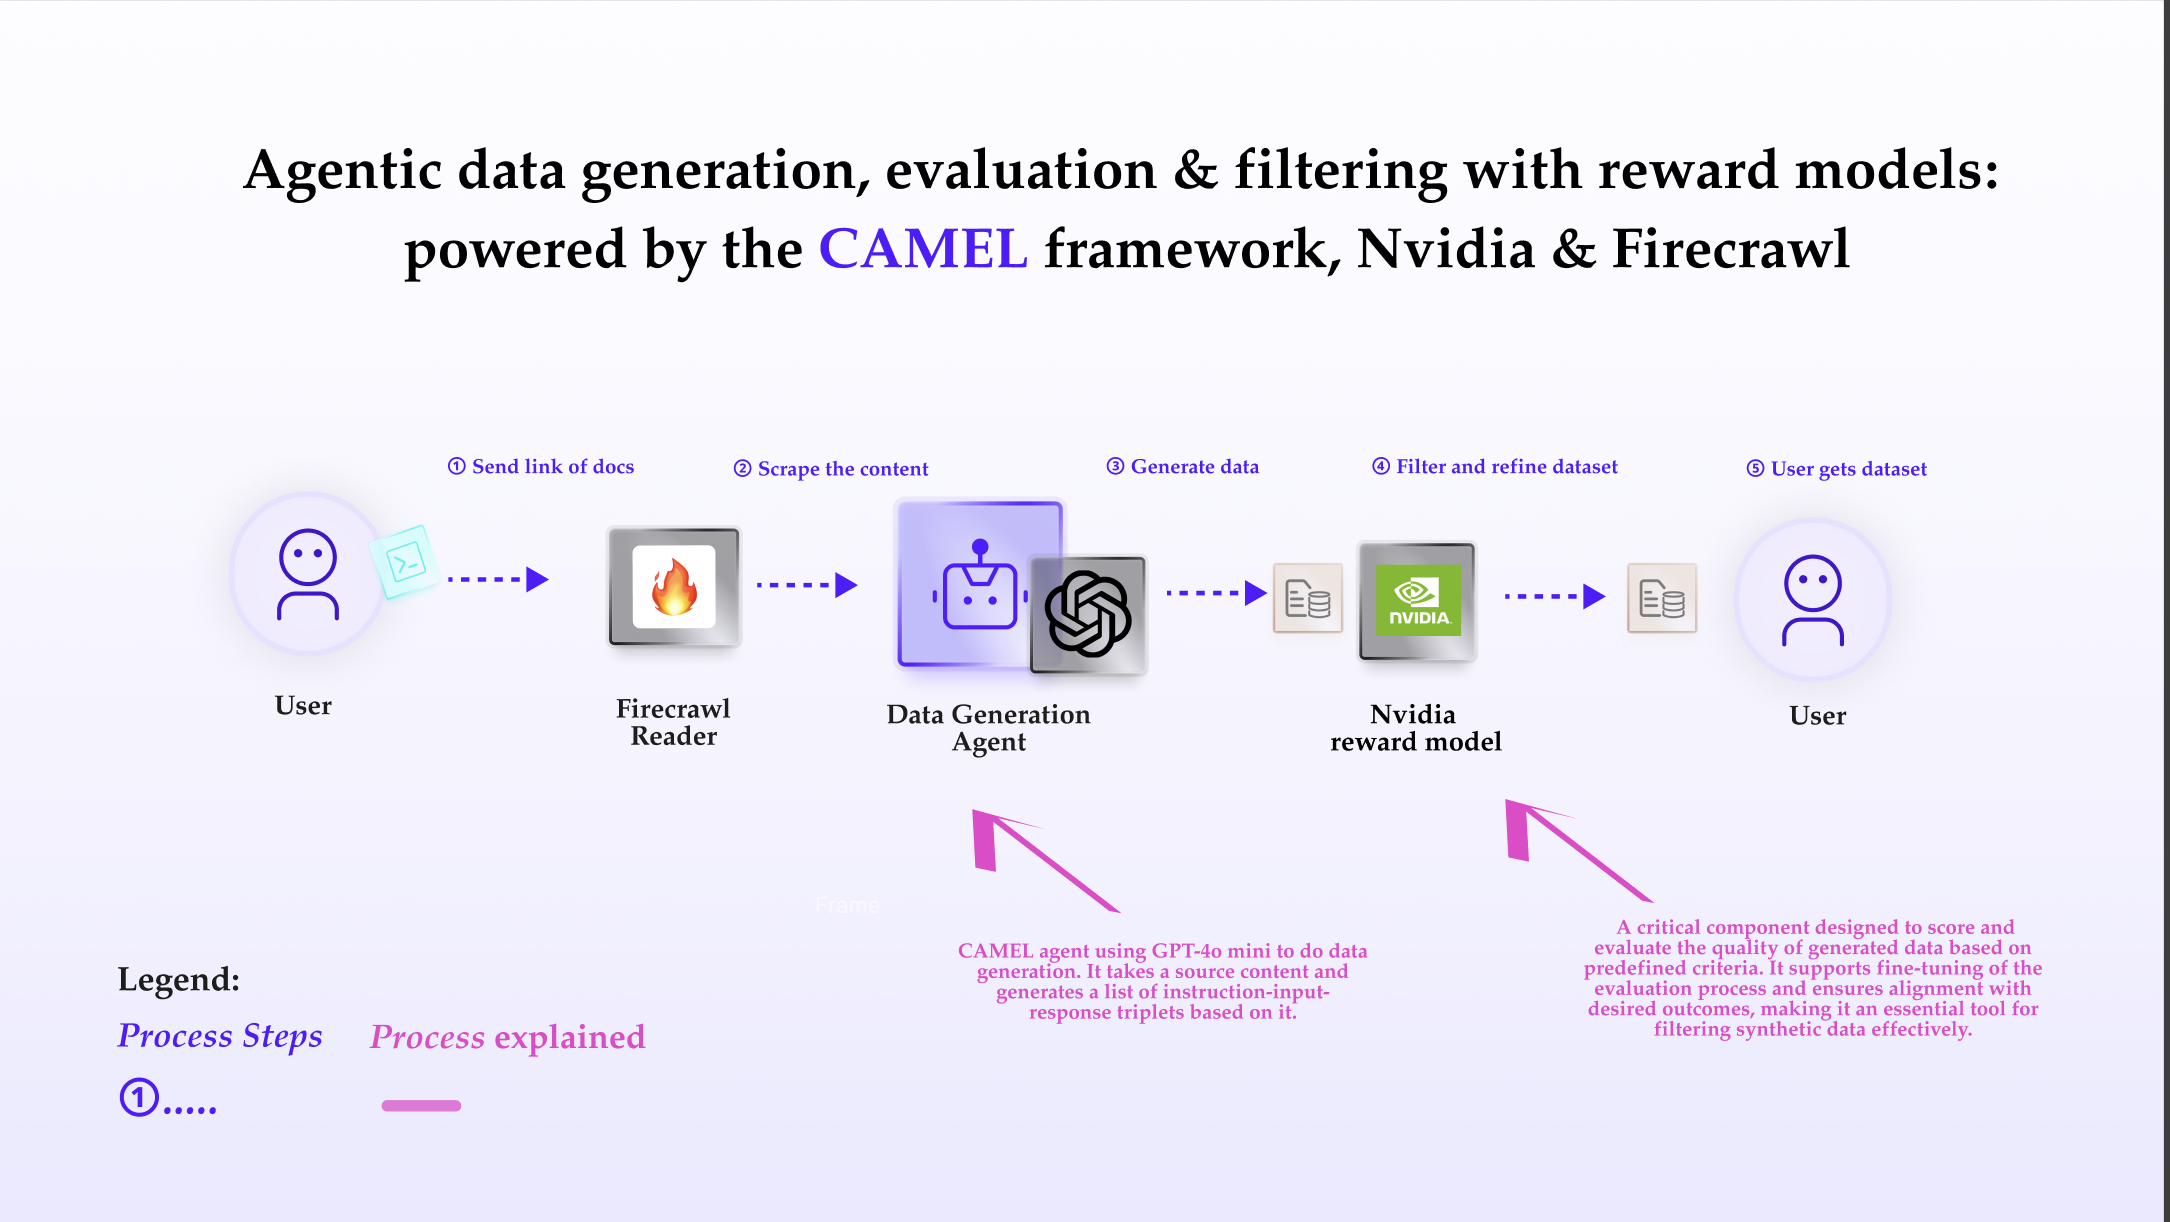

## 📦 Installation

First, install the CAMEL package with its dependencies

In [ ]:
!pip install "camel-ai[web_tools]==0.2.16"

Next, we need to securely input and store the required API keys for accessing OpenAI, Firecrawl, and NVIDIA services.

In [ ]:
from getpass import getpass
import os

openai_api_key = getpass('Enter your OpenAI API key: ')
os.environ["OPENAI_API_KEY"] = openai_api_key

# Generate an API key at https://www.firecrawl.dev/app/api-keys
firecrawl_api_key = getpass('Enter your Firecrawl API key: ')
os.environ["FIRECRAWL_API_KEY"] = firecrawl_api_key

# Generate an API key at https://build.nvidia.com/nvidia/nemotron-4-340b-reward
nvidia_api_key = getpass('Enter your NVIDIA API key: ')
os.environ["NVIDIA_API_KEY"] = nvidia_api_key

Enter your OpenAI API key: ··········
Enter your Firecrawl API key: ··········
Enter your NVIDIA API key: ··········


Alternatively, if running on Colab, you could save your API keys and tokens as **Colab Secrets**, and use them across notebooks.

To do so, **comment out** the above **manual** API key prompt code block(s), and **uncomment** the following codeblock.

⚠️ Don't forget granting access to the API key you would be using to the current notebook.

In [ ]:
# import os
# from google.colab import userdata

# os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
# os.environ["FIRECRAWL_API_KEY"] = userdata.get("FIRECRAWL_API_KEY")
# os.environ["NVIDIA_API_KEY"] = userdata.get("NVIDIA_API_KEY")

To work effectively with the Alpaca format and manage items systematically, we define a set of models using Pydantic. These models ensure that the data is well-structured, type-safe, and validated.

In [ ]:
from pydantic import BaseModel
from camel.messages.conversion import AlpacaItem

class NumberedAlpacaItem(BaseModel):
    number: int
    item: AlpacaItem


class AlpacaItemResponse(BaseModel):
    """
    Represents an instruction-response item in the Alpaca format.
    """
    items: list[NumberedAlpacaItem]

## 🚀 Data Generation
Next, we define our data generation function. It takes a source content and generates a list of instruction-input-response triplets based on it.

Later, we will use a reward model to filter this list.

In [ ]:
from typing import List
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from camel.configs import ChatGPTConfig
from camel.agents import ChatAgent

def generate_alpaca_items(content: str, n_items: int, start_num: int = 1, examples: List[AlpacaItem] = None) -> List[AlpacaItem]:
    system_msg = """
You are an AI assistant generating detailed, accurate responses based on the provided content.
You will be given a reference content, and you must generate a specific number of AlpacaItems.
These are instruction-input-response triplets, where the input is the context or examples.

Add a number to the items to keep track of the order. Generate exactly that many.

For each instruction, imagine but do not include a real world scenario and real user in that scenario to inform realistic and varied instructions. Avoid common sense questions and answers.

Include multiple lines in the output as appropriate to provide sufficient detail. Cite the most relevant context verbatim in output fields, do not omit anything important.

Leave the input field blank.

Ensure all of the most significant parts of the context are covered.

Start with open ended instructions, then move to more specific ones. Consider the starting number for an impression of what has already been generated.
    """

    examples_str = ""
    if examples:
        examples_str = "\n\nHere are some example items for reference:\n" + \
            "\n".join(ex.model_dump_json() for ex in examples)

    model = ModelFactory.create(
        model_platform=ModelPlatformType.OPENAI,
        model_type=ModelType.GPT_4O_MINI,
        model_config_dict=ChatGPTConfig(
            temperature=0.6, response_format=AlpacaItemResponse
        ).as_dict(),
    )

    agent = ChatAgent(
        system_message=system_msg,
        model=model,
    )

    prompt = f"Content reference:\n{content}{examples_str}\n\n Generate {n_items} AlpacaItems. The first should start numbering at {start_num}."
    response = agent.step(prompt)

    # Parse the generated JSON to our wrapper class
    alpaca_items = [n_item.item for n_item in
                    AlpacaItemResponse.
                    model_validate_json(response.msgs[0].content).items]

    return alpaca_items

# Few shot examples to ensure the right amount of detail
examples = [
    AlpacaItem(
        instruction="Explain the process for sprint planning and review in CAMEL.",
        input="",
        output="The process for sprint planning and review in CAMEL includes:\n1. **Sprint Duration**: Each sprint lasts two weeks for development and one week for review.\n2. **Planning Meeting**: Conducted biweekly, where the founder highlights the sprint goal and developers select items for the sprint.\n3. **Review Meeting**: Stakeholders review the delivered features and provide feedback on the work completed during the sprint."
    )
]

## 📊 Point to content and generate data!
Now we point to the content that we wish to generate SFT data around and use CAMEL's Firecrawl integration to get this content in a nice markdown format.


In [ ]:
import random
from camel.loaders.firecrawl_reader import Firecrawl
firecrawl = Firecrawl()
# Scrape and clean content from a specified URL
response = firecrawl.scrape(
    url="https://github.com/camel-ai/camel/blob/master/CONTRIBUTING.md"
)

# Generate the items 50 a time up to 50
alpaca_entries = []
for start in range(1, 51, 50):
    # Combine default examples with random samples from previous generations
    current_examples = examples + (random.sample(alpaca_entries,
                            min(5, len(alpaca_entries)))
                            if alpaca_entries else [])

    batch = generate_alpaca_items(
        content=response["markdown"],
        n_items=50,
        start_num=start,
        examples=current_examples
    )
    print(f"Generated {len(batch)} items")
    alpaca_entries.extend(batch)

print(alpaca_entries)

Generated 50 items
[AlpacaItem(instruction='Summarize the contributing guidelines for the CAMEL project.', input='', output='The contributing guidelines for the CAMEL project include:\n1. **Types of Contributions**: Contributions can include new features, infrastructure enhancements, documentation improvements, issue reporting, and bug fixes.\n2. **Workflow**: Community contributors should follow the Fork-and-Pull-Request workflow, while members of CAMEL-AI.org should use the Checkout-and-Pull-Request workflow.\n3. **Pull Requests**: Mention related issues and tag relevant maintainers. Pull requests must pass formatting, linting, and testing checks before merging.'), AlpacaItem(instruction='What are the steps for writing a cookbook entry for CAMEL?', input='', output='The steps for writing a cookbook entry for CAMEL are:\n1. **Template Usage**: Use the provided template for consistency.\n2. **Writing in Colab**: Write your cookbook in Google Colab, ensuring that LLM-generated responses

In [ ]:
len(alpaca_entries)

50

## 🔄 Code for Conversion to Reward Model Format
Next, we transform the Alpaca-style entries into a format compatible with the reward model. Each entry will be converted into a structured list of instruction-input-response pairs that the reward model can evaluate.

In [ ]:
messages_lists=[]
for item in alpaca_entries:
    messages_list =[]
    user_content = item.instruction
    if item.input:
        user_content += f"\nInput: {item.input}"
    messages_list.append({"role": "user", "content": user_content})
    messages_list.append({"role": "assistant", "content": item.output})
    messages_lists.append(messages_list)

## ✨Test Reward Model
Then, we can test the reward model to check its output format and use it as a reference to set the filtering criteria.


In [ ]:
from camel.models.reward import Evaluator, NemotronRewardModel
from camel.types import ModelType

reward_model = NemotronRewardModel(
    model_type=ModelType.NVIDIA_NEMOTRON_340B_REWARD,
    url="https://integrate.api.nvidia.com/v1",
)
evaluator = Evaluator(reward_model=reward_model)
results = []  # To store results for comparison
for i in range(min(10, len(messages_lists))):
    print(f"Evaluating message list {i+1}:")
    print(messages_lists[i])  # Display the message list
    scores = evaluator.evaluate(messages_lists[i])
    print(f"Scores: {scores}\n")  # Print the evaluation scores
    results.append((i + 1, messages_lists[i], scores))

# Print a summary of the results
print("\nSummary of evaluations:")
for index, messages, scores in results:
    print(f"Message List {index}:")
    print(messages)
    print(f"Scores: {scores}\n")


Evaluating message list 1:
[{'role': 'user', 'content': 'Summarize the contributing guidelines for the CAMEL project.'}, {'role': 'assistant', 'content': 'The contributing guidelines for the CAMEL project include:\n1. **Types of Contributions**: Contributions can include new features, infrastructure enhancements, documentation improvements, issue reporting, and bug fixes.\n2. **Workflow**: Community contributors should follow the Fork-and-Pull-Request workflow, while members of CAMEL-AI.org should use the Checkout-and-Pull-Request workflow.\n3. **Pull Requests**: Mention related issues and tag relevant maintainers. Pull requests must pass formatting, linting, and testing checks before merging.'}]
Scores: {'helpfulness': 2.21875, 'correctness': 2.40625, 'coherence': 3.453125, 'complexity': 1.6640625, 'verbosity': 1.078125}

Evaluating message list 2:
[{'role': 'user', 'content': 'What are the steps for writing a cookbook entry for CAMEL?'}, {'role': 'assistant', 'content': 'The steps fo

## 🎯Filtering the Generated Data Using the Reward Model
 Finally, we utilize NVIDIA's Nemotron Reward Model to filter out low-quality instruction-input-response triplets. The model evaluates each response based on defined thresholds for metrics such as helpfulness and correctness.

 Let's use thresholds = `{"helpfulness": 2.5, "correctness": 2.5}` as an example of filter parameters. After filtering, some high-quality triplets are retained.

In [ ]:
thresholds = {"helpfulness": 2.5, "correctness": 2.5}
filtered_messages_lists = []
for messages_list in messages_lists:
    response = evaluator.filter_data(messages_list, thresholds)
    if response:
        filtered_messages_lists.append(messages_list)

print(len(filtered_messages_lists))


18


In [ ]:
filtered_messages_lists

[[{'role': 'user',
   'content': 'What are the steps for writing a cookbook entry for CAMEL?'},
  {'role': 'assistant',
   'content': 'The steps for writing a cookbook entry for CAMEL are:\n1. **Template Usage**: Use the provided template for consistency.\n2. **Writing in Colab**: Write your cookbook in Google Colab, ensuring that LLM-generated responses are correct and verified.\n3. **Clear Explanations**: Provide clear explanations of the code and its purpose.\n4. **Review and Submit**: After writing, review in Colab, then submit by downloading the notebook and creating a pull request.'}],
 [{'role': 'user',
   'content': 'Explain the importance of code coverage in CAMEL.'},
  {'role': 'assistant',
   'content': 'Code coverage is important in CAMEL because it measures how much of the code is tested by unit tests. This helps in identifying robust areas of the codebase and areas that may need more testing, ensuring better reliability and maintainability of the code.'}],
 [{'role': 'use

## 🌟 Highlights

That's everything: Got questions about 🐫 CAMEL-AI? Join us on [Discord](https://discord.camel-ai.org)! Whether you want to share feedback, explore the latest in multi-agent systems, get support, or connect with others on exciting projects, we’d love to have you in the community! 🤝

Summary of This Cookbook:
In this cookbook, we demonstrated how to leverage CAMEL-AI to filter generate data. This practical guide helps you efficiently evaluate synthetic data.

Check out some of our other work:

1. 🐫 Creating Your First CAMEL Agent [free Colab](https://docs.camel-ai.org/cookbooks/create_your_first_agent.html)

2. 🔥 3 ways to ingest data from websites with Firecrawl & CAMEL [free Colab](https://colab.research.google.com/drive/1lOmM3VmgR1hLwDKdeLGFve_75RFW0R9I?usp=sharing)

3. 🦥 Agentic SFT Data Generation with CAMEL and Mistral Models, Fine-Tuned with Unsloth [free Colab](https://colab.research.google.com/drive/1lYgArBw7ARVPSpdwgKLYnp_NEXiNDOd-?usp=sharingg)

Thanks from everyone at 🐫 CAMEL-AI


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on <a href="https://github.com/camel-ai/camel">Github</a> </i>, join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)  ⭐
</div>